#<font color='Navy'>**Import Essential Libraries**</font>

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os, fnmatch, glob
from glob import glob 
from sklearn.model_selection import train_test_split
%matplotlib inline
from PIL import Image
import torchvision.transforms as tfs
from torch.autograd import Variable as gradEnb
import torch.nn.functional as F
import torch.optim as optim

#<font color='Navy'>**Utilities**</font>

In [ ]:
#http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colors.txt
color_dict = {0: (64, 128, 64),
              1: (192, 0, 128),
              2: (0, 128, 192),
              3: (0, 128, 64),
              4: (128, 0, 0),
              5: (64, 0, 128),
              6: (64, 0, 192),
              7:(192, 128, 64),
              8:(192, 192, 128),
              9:(64, 64, 128),
              10:(128, 0, 192),
              11:(192, 0, 64),
              12:(128, 128, 64),
              13:(192, 0, 192),
              14:(128, 64, 64),
              15:(64, 192, 128),
              16:(64, 64, 0),
              17:(128, 64, 128),
              18:(128, 128, 192),
              19:(0, 0, 192),
              20:(192, 128, 128),
              21:(128, 128, 128),
              22:(64, 128, 192),
              23:(0, 0, 64),
              24:(0, 64, 64),
              25:(192, 64, 128),
              26:(128, 128, 0),
              27:(192, 128, 192),
              28:(64, 0, 64),
              29:(192, 192, 0),
              30:(0, 0, 0),
              31:(64, 192, 0)}


#https://stackoverflow.com/questions/43884463/how-to-convert-rgb-image-to-one-hot-encoded-3d-array-based-on-color-using-numpy
def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=0)
    output = np.zeros( onehot.shape[1:3]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images, label in dl:
        label = label.numpy()
        labi = []
        for lab in label:
          labi.append(onehot_to_rgb(lab, color_dict))
        labi = np.asarray(labi)
        labi = torch.from_numpy(labi)
        show_images(images, nmax)
        show_images(labi, nmax)
        break

In [ ]:
#https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def resize(img, new_width, new_height):
  width, height = img.size
  left = (width - new_width)/2
  top = (height - new_height)/2
  right = (width + new_width)/2
  bottom = (height + new_height)/2
  # Crop the center of the image
  img = img.crop((left, top, right, bottom))
  return img



In [ ]:
def showResults(epoch_,originalImg, label, predictedResult):
  trans = tfs.Compose([
          tfs.ToTensor(),
          tfs.Normalize([-0.485, -0.456, -0.406], [1/0.229, 1/0.224, 1/0.225])
      ])
  origImg = trans(originalImg[0].transpose([1,2,0]))
  max_idx = torch.argmax(predictedResult, 1, keepdim=True)
  one_hot = torch.FloatTensor(predictedResult.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  labRGB = onehot_to_rgb(label[0], color_dict)
  outRGB = onehot_to_rgb(one_hot[0], color_dict)
  fig, axs = plt.subplots(1, 3, figsize=(15,5))
  fig.suptitle('Epoch %d'%epoch_)
  axs[0].imshow(origImg.numpy().transpose([1,2,0]))
  axs[0].set_title('Original Image')
  axs[1].imshow(labRGB)
  axs[1].set_title('True Label')
  axs[2].imshow(outRGB)
  axs[2].set_title('Predicted Output')
  plt.show()

In [ ]:
def calcTestLoss(testloader, net, criterion):
  totalLoss = 0; i = 0
  net.eval()
  with torch.no_grad():
    for img,  imLabel in testloader:
      if torch.cuda.is_available:
        img = img.cuda()
        imLabel =  imLabel.cuda()
      i +=1
      outputs = net(img)
      imLabel_Clnmb = torch.argmax(imLabel, dim=1)
      loss = criterion(outputs, imLabel_Clnmb)
      totalLoss += loss.item()
  avgLoss = totalLoss/i
  return avgLoss

In [ ]:
def plotLoss(epoch, trainLoss, testLoss):
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy Loss')
  plt.title('Loss')
  plt.plot(epoch, trainLoss, label='Train')
  plt.plot(epoch, testLoss, label = '،Test')
  plt.legend(loc='upper left')
  plt.show()

#<font color='Navy'>**Data Loader**</font>

In [ ]:
class camVidPreprocessor:
  def __init__(self, width, height):
    self.width = width
    self.height = height
  def imgTransformer(self, data):
      data = resize(data, self.width, self.height)
      # Convert the data to tensor and do standardization
      trans = tfs.Compose([
          tfs.ToTensor(),
          tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
      data = trans(data)
      return data
  def camVidTrans(self, data, label):
    imgTrans = self.imgTransformer(data)
    label = resize(label, self.width, self.height)
    label = rgb_to_onehot(np.asarray(label), color_dict)
    trans = tfs.Compose([
          tfs.ToTensor()])
    label =  trans(label)
    label = torch.from_numpy( np.array(label)).long()
    return imgTrans, label

In [ ]:
class camVidDataset(Dataset):
  def __init__(self, transformer, dataDirs, labelDirs):
    self.trans = transformer
    self.data_list = dataDirs
    self.label_list = labelDirs
  def __getitem__(self, idx):
    img = Image.open(self.data_list[idx])
    label = Image.open(self.label_list[idx])
    img, label = self.trans.camVidTrans(img, label)
    return  img, label
  def __len__(self):
    return len(self.data_list)

#<font color='Navy'>**Preparing Data**</font>

In [ ]:
dataBaseAddr = '/content/drive/MyDrive/Hw2/Camvid/camvid/images/*.png'
labelBaseAddr = '/content/drive/MyDrive/Hw2/Label/*.png'
dataDir = sorted(glob(dataBaseAddr))
labelDir = sorted(glob(labelBaseAddr))

In [ ]:
trainDataDir, testDataDir, trainLabelDir, testLabelDir = train_test_split(dataDir, labelDir, test_size=0.2, random_state=1)

In [ ]:
camvidTrans = camVidPreprocessor(width = 480, height = 360)
trainData = camVidDataset(transformer = camvidTrans, dataDirs = trainDataDir, labelDirs = trainLabelDir)
testData = camVidDataset(transformer = camvidTrans, dataDirs = testDataDir, labelDirs = testLabelDir)
BATCHSIZE = 4
trainDataCamvid = DataLoader(trainData, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
testDataCamvid = DataLoader(testData, batch_size=BATCHSIZE, shuffle=True, num_workers=2)  

#<font color='Navy'>**Segnet Architecture**</font>

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
      super(SegNet, self).__init__()
      PAD = 3
      DIL = 1
      BATCHMOM = 0.1
      self.encoder1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7,7), padding = PAD, dilation = DIL), nn.ReLU())
      self.encoder2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(7,7), padding = PAD, dilation = DIL), nn.ReLU())
      self.encoder3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(7,7), padding = PAD, dilation = DIL), nn.ReLU())
      self.encoder4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(7,7), padding = PAD, dilation = DIL), nn.ReLU())
      self.decoder4 =  nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(7,7), padding = PAD,dilation = DIL))
      self.decoder3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(7,7), padding = PAD,dilation = DIL))
      self.decoder2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(7,7), padding = PAD,dilation = DIL))
      self.decoder1 =nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(7,7), padding = PAD,dilation = DIL))
      self.activation = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1,1))
    def forward(self, x):
      x1, indDec1 = F.max_pool2d(self.encoder1(x), kernel_size=2, stride=2, return_indices=True)
      x2, indDec2 = F.max_pool2d(self.encoder2(x1), kernel_size=2, stride=2, return_indices=True)
      x3, indDec3 = F.max_pool2d( self.encoder3(x2), kernel_size=2, stride=2, return_indices=True)
      x4, indDec4 = F.max_pool2d( self.encoder4(x3), kernel_size=2, stride=2, return_indices=True)
      x5 = self.decoder4(F.max_unpool2d(x4, indDec4, kernel_size=2, stride=2))
      x5 = F.pad(x5, (0,0,1,0)) 
      x6 = self.decoder3(F.max_unpool2d(x5, indDec3, kernel_size=2, stride=2))
      x7 = self.decoder2(F.max_unpool2d(x6, indDec2, kernel_size=2, stride=2))
      x8 = self.decoder2(F.max_unpool2d(x7, indDec1, kernel_size=2, stride=2))
      xOut = self.activation(x8)
      return xOut

#<font color='Navy'>**Training**</font>

In [ ]:
num_classes = 32
net = SegNet()
lossTrainHist = []; lossTestHist = []; epochHist = []
if torch.cuda.is_available():
    net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

**********Epoch: 1 **********
 Epoch 1,  Iteration     9,  Loss: 3.459
 Epoch 1,  Iteration    19,  Loss: 3.455
 Epoch 1,  Iteration    29,  Loss: 3.448
 Epoch 1,  Iteration    39,  Loss: 3.443
 Epoch 1,  Iteration    49,  Loss: 3.436
 Epoch 1,  Iteration    59,  Loss: 3.430
 Epoch 1,  Iteration    69,  Loss: 3.423
 Epoch 1,  Iteration    79,  Loss: 3.416
 Epoch 1,  Iteration    89,  Loss: 3.410
 Epoch 1,  Iteration    99,  Loss: 3.403
 Epoch 1,  Iteration   109,  Loss: 3.396
 Epoch 1,  Iteration   119,  Loss: 3.388
 Epoch 1,  Iteration   129,  Loss: 3.380
 Epoch 1,  Iteration   139,  Loss: 3.373
TestLoss:  3.272121879789564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


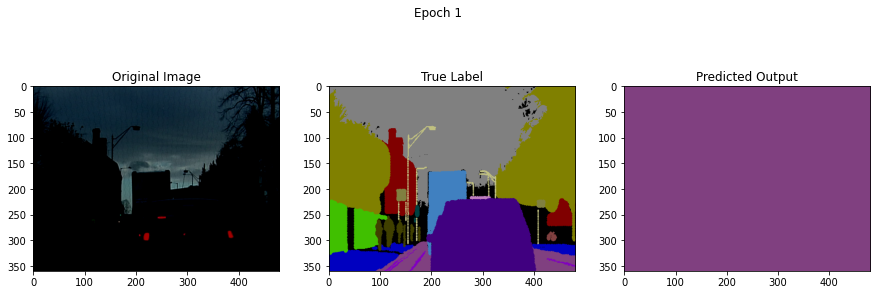

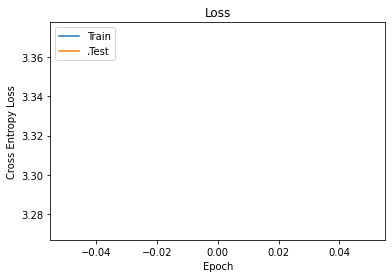

**********Epoch: 2 **********
 Epoch 2,  Iteration     9,  Loss: 3.263
 Epoch 2,  Iteration    19,  Loss: 3.255
 Epoch 2,  Iteration    29,  Loss: 3.248
 Epoch 2,  Iteration    39,  Loss: 3.239
 Epoch 2,  Iteration    49,  Loss: 3.230
 Epoch 2,  Iteration    59,  Loss: 3.219
 Epoch 2,  Iteration    69,  Loss: 3.207
 Epoch 2,  Iteration    79,  Loss: 3.199
 Epoch 2,  Iteration    89,  Loss: 3.189
 Epoch 2,  Iteration    99,  Loss: 3.178
 Epoch 2,  Iteration   109,  Loss: 3.170
 Epoch 2,  Iteration   119,  Loss: 3.161
 Epoch 2,  Iteration   129,  Loss: 3.150
 Epoch 2,  Iteration   139,  Loss: 3.139
TestLoss:  2.9939621090888977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


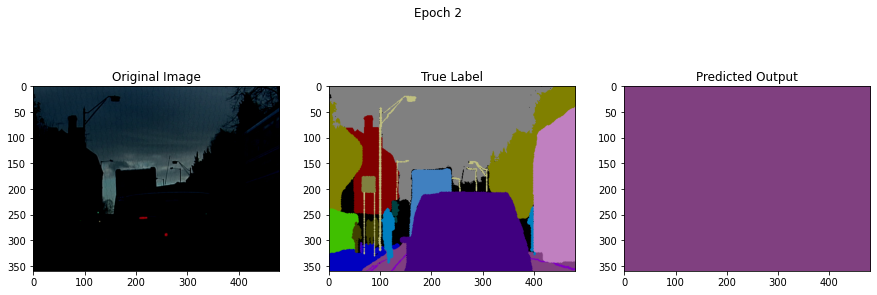

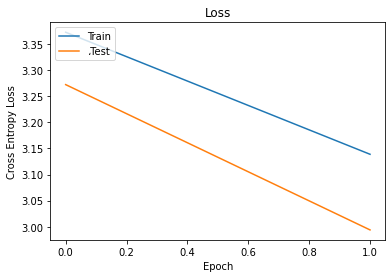

**********Epoch: 3 **********
 Epoch 3,  Iteration     9,  Loss: 2.996
 Epoch 3,  Iteration    19,  Loss: 2.966
 Epoch 3,  Iteration    29,  Loss: 2.941
 Epoch 3,  Iteration    39,  Loss: 2.922
 Epoch 3,  Iteration    49,  Loss: 2.908
 Epoch 3,  Iteration    59,  Loss: 2.896
 Epoch 3,  Iteration    69,  Loss: 2.877
 Epoch 3,  Iteration    79,  Loss: 2.858
 Epoch 3,  Iteration    89,  Loss: 2.837
 Epoch 3,  Iteration    99,  Loss: 2.819
 Epoch 3,  Iteration   109,  Loss: 2.798
 Epoch 3,  Iteration   119,  Loss: 2.778
 Epoch 3,  Iteration   129,  Loss: 2.766
 Epoch 3,  Iteration   139,  Loss: 2.749
TestLoss:  2.536411921183268


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


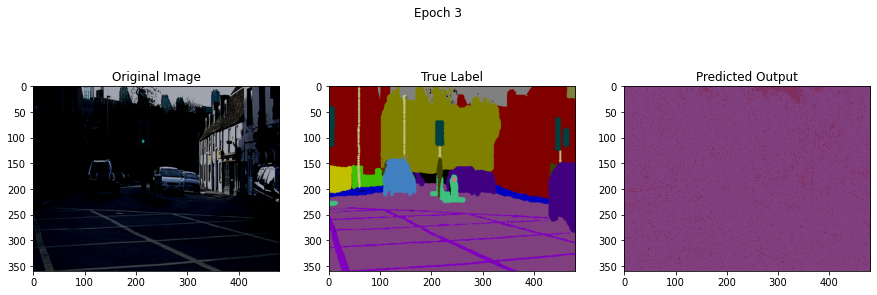

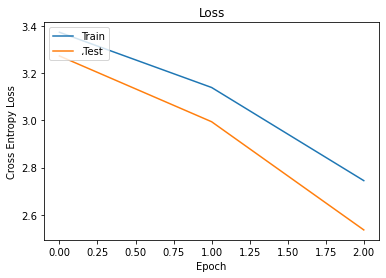

**********Epoch: 4 **********
 Epoch 4,  Iteration     9,  Loss: 2.472
 Epoch 4,  Iteration    19,  Loss: 2.476
 Epoch 4,  Iteration    29,  Loss: 2.487
 Epoch 4,  Iteration    39,  Loss: 2.487
 Epoch 4,  Iteration    49,  Loss: 2.494
 Epoch 4,  Iteration    59,  Loss: 2.490
 Epoch 4,  Iteration    69,  Loss: 2.478
 Epoch 4,  Iteration    79,  Loss: 2.464
 Epoch 4,  Iteration    89,  Loss: 2.449
 Epoch 4,  Iteration    99,  Loss: 2.442
 Epoch 4,  Iteration   109,  Loss: 2.441
 Epoch 4,  Iteration   119,  Loss: 2.439
 Epoch 4,  Iteration   129,  Loss: 2.433
 Epoch 4,  Iteration   139,  Loss: 2.430
TestLoss:  2.3859847585360208


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


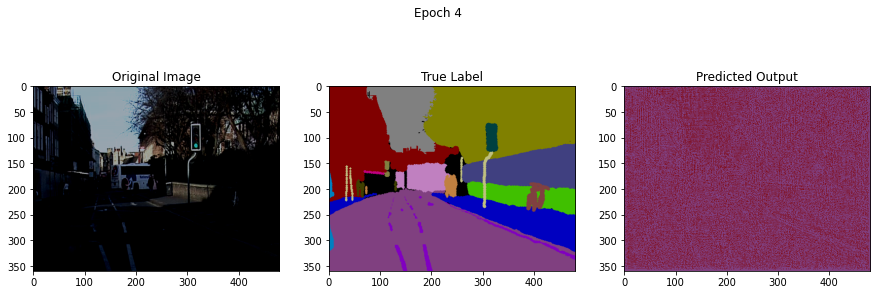

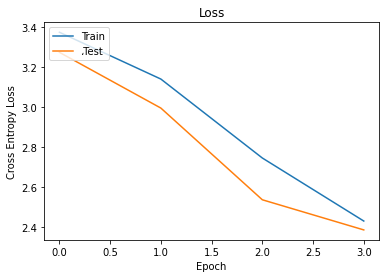

**********Epoch: 5 **********
 Epoch 5,  Iteration     9,  Loss: 2.309
 Epoch 5,  Iteration    19,  Loss: 2.334
 Epoch 5,  Iteration    29,  Loss: 2.343
 Epoch 5,  Iteration    39,  Loss: 2.360
 Epoch 5,  Iteration    49,  Loss: 2.361
 Epoch 5,  Iteration    59,  Loss: 2.360
 Epoch 5,  Iteration    69,  Loss: 2.362
 Epoch 5,  Iteration    79,  Loss: 2.364
 Epoch 5,  Iteration    89,  Loss: 2.371
 Epoch 5,  Iteration    99,  Loss: 2.371
 Epoch 5,  Iteration   109,  Loss: 2.368
 Epoch 5,  Iteration   119,  Loss: 2.360
 Epoch 5,  Iteration   129,  Loss: 2.361
 Epoch 5,  Iteration   139,  Loss: 2.360
TestLoss:  2.3451774385240345


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


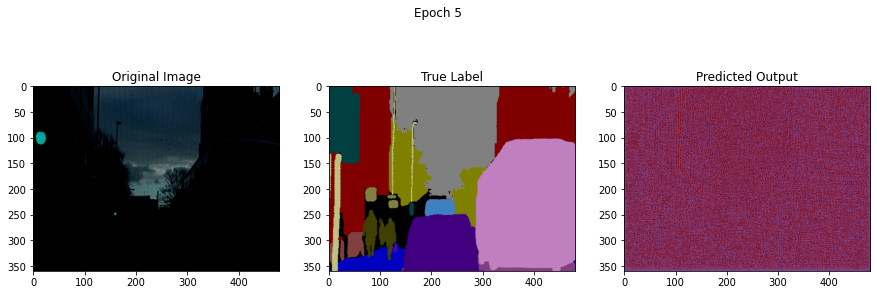

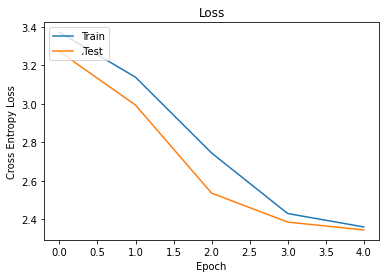

**********Epoch: 6 **********
 Epoch 6,  Iteration     9,  Loss: 2.423
 Epoch 6,  Iteration    19,  Loss: 2.377
 Epoch 6,  Iteration    29,  Loss: 2.380
 Epoch 6,  Iteration    39,  Loss: 2.388
 Epoch 6,  Iteration    49,  Loss: 2.381
 Epoch 6,  Iteration    59,  Loss: 2.376
 Epoch 6,  Iteration    69,  Loss: 2.368
 Epoch 6,  Iteration    79,  Loss: 2.354
 Epoch 6,  Iteration    89,  Loss: 2.344
 Epoch 6,  Iteration    99,  Loss: 2.337
 Epoch 6,  Iteration   109,  Loss: 2.338
 Epoch 6,  Iteration   119,  Loss: 2.342
 Epoch 6,  Iteration   129,  Loss: 2.341
 Epoch 6,  Iteration   139,  Loss: 2.343
TestLoss:  2.333542777432336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


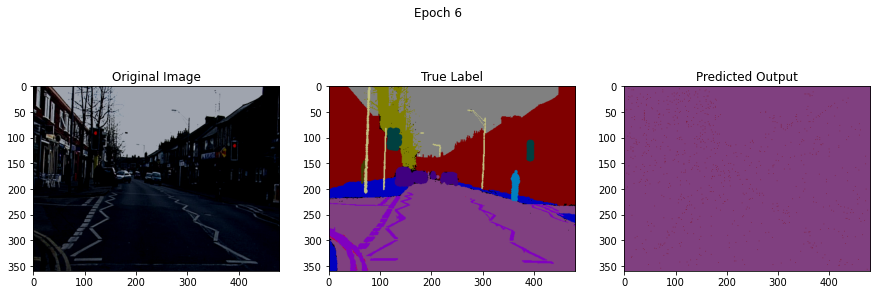

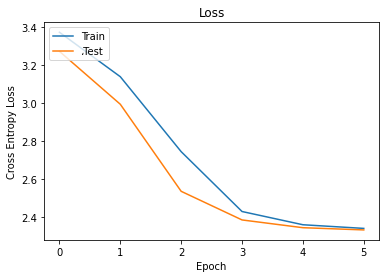

**********Epoch: 7 **********
 Epoch 7,  Iteration     9,  Loss: 2.352
 Epoch 7,  Iteration    19,  Loss: 2.346
 Epoch 7,  Iteration    29,  Loss: 2.335
 Epoch 7,  Iteration    39,  Loss: 2.328
 Epoch 7,  Iteration    49,  Loss: 2.325
 Epoch 7,  Iteration    59,  Loss: 2.329
 Epoch 7,  Iteration    69,  Loss: 2.323
 Epoch 7,  Iteration    79,  Loss: 2.322
 Epoch 7,  Iteration    89,  Loss: 2.319
 Epoch 7,  Iteration    99,  Loss: 2.325
 Epoch 7,  Iteration   109,  Loss: 2.331
 Epoch 7,  Iteration   119,  Loss: 2.333
 Epoch 7,  Iteration   129,  Loss: 2.332
 Epoch 7,  Iteration   139,  Loss: 2.331
TestLoss:  2.3169534107049308


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


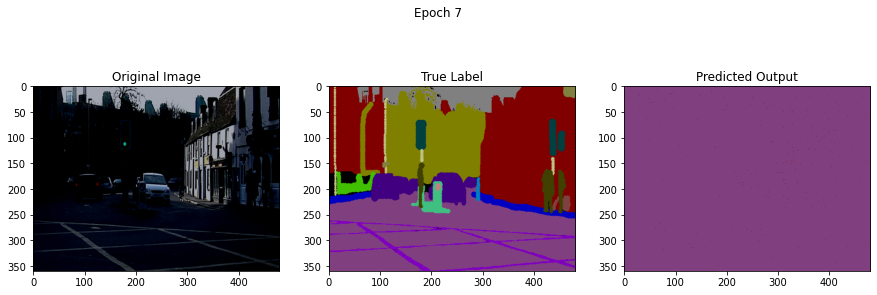

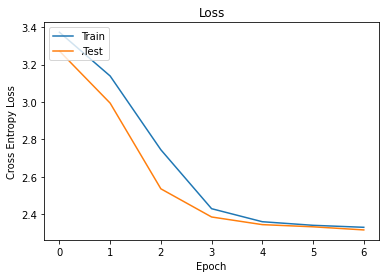

**********Epoch: 8 **********
 Epoch 8,  Iteration     9,  Loss: 2.380
 Epoch 8,  Iteration    19,  Loss: 2.378
 Epoch 8,  Iteration    29,  Loss: 2.357
 Epoch 8,  Iteration    39,  Loss: 2.348
 Epoch 8,  Iteration    49,  Loss: 2.329
 Epoch 8,  Iteration    59,  Loss: 2.325
 Epoch 8,  Iteration    69,  Loss: 2.324
 Epoch 8,  Iteration    79,  Loss: 2.319
 Epoch 8,  Iteration    89,  Loss: 2.325
 Epoch 8,  Iteration    99,  Loss: 2.326
 Epoch 8,  Iteration   109,  Loss: 2.323
 Epoch 8,  Iteration   119,  Loss: 2.320
 Epoch 8,  Iteration   129,  Loss: 2.323
 Epoch 8,  Iteration   139,  Loss: 2.325
TestLoss:  2.3139332930246987


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


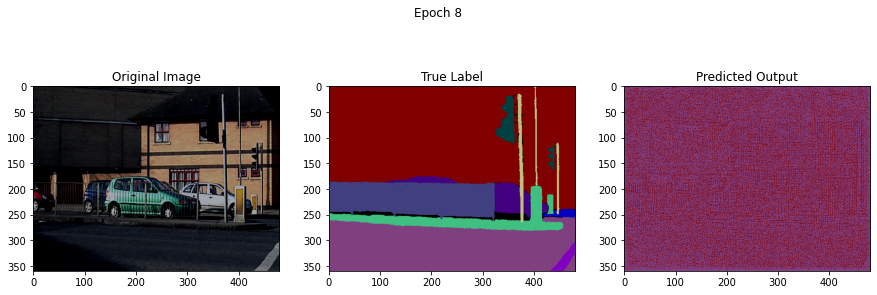

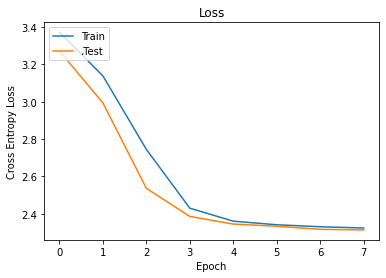

**********Epoch: 9 **********
 Epoch 9,  Iteration     9,  Loss: 2.321
 Epoch 9,  Iteration    19,  Loss: 2.325
 Epoch 9,  Iteration    29,  Loss: 2.330
 Epoch 9,  Iteration    39,  Loss: 2.313
 Epoch 9,  Iteration    49,  Loss: 2.315
 Epoch 9,  Iteration    59,  Loss: 2.306
 Epoch 9,  Iteration    69,  Loss: 2.305
 Epoch 9,  Iteration    79,  Loss: 2.305
 Epoch 9,  Iteration    89,  Loss: 2.298
 Epoch 9,  Iteration    99,  Loss: 2.302
 Epoch 9,  Iteration   109,  Loss: 2.302
 Epoch 9,  Iteration   119,  Loss: 2.309
 Epoch 9,  Iteration   129,  Loss: 2.316
 Epoch 9,  Iteration   139,  Loss: 2.318
TestLoss:  2.311870356400808


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


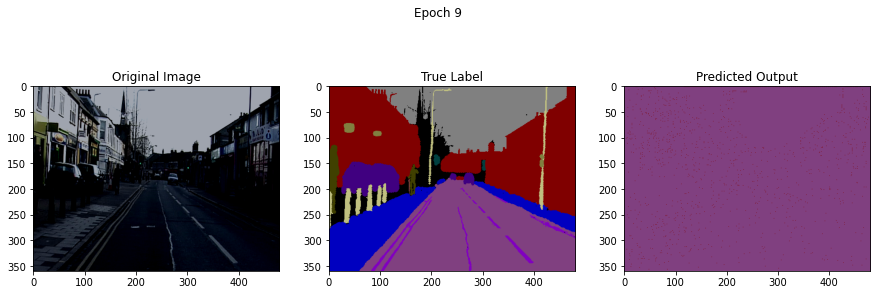

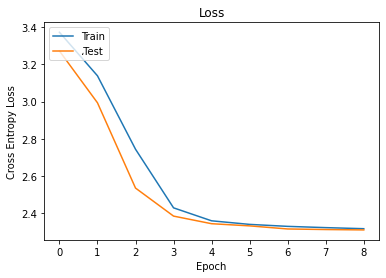

**********Epoch: 10 **********
 Epoch 10,  Iteration     9,  Loss: 2.283
 Epoch 10,  Iteration    19,  Loss: 2.305
 Epoch 10,  Iteration    29,  Loss: 2.291
 Epoch 10,  Iteration    39,  Loss: 2.304
 Epoch 10,  Iteration    49,  Loss: 2.300
 Epoch 10,  Iteration    59,  Loss: 2.312
 Epoch 10,  Iteration    69,  Loss: 2.313
 Epoch 10,  Iteration    79,  Loss: 2.307
 Epoch 10,  Iteration    89,  Loss: 2.307
 Epoch 10,  Iteration    99,  Loss: 2.310
 Epoch 10,  Iteration   109,  Loss: 2.309
 Epoch 10,  Iteration   119,  Loss: 2.308
 Epoch 10,  Iteration   129,  Loss: 2.307
 Epoch 10,  Iteration   139,  Loss: 2.315
TestLoss:  2.3040427499347262


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


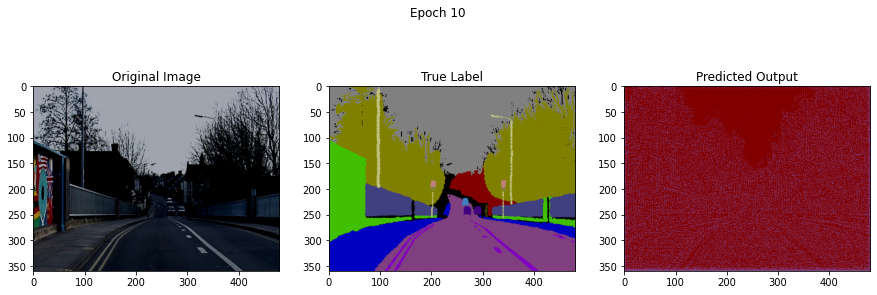

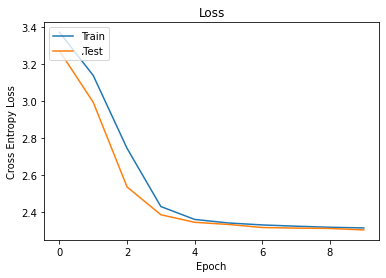

**********Epoch: 11 **********
 Epoch 11,  Iteration     9,  Loss: 2.329
 Epoch 11,  Iteration    19,  Loss: 2.338
 Epoch 11,  Iteration    29,  Loss: 2.320
 Epoch 11,  Iteration    39,  Loss: 2.308
 Epoch 11,  Iteration    49,  Loss: 2.300
 Epoch 11,  Iteration    59,  Loss: 2.299
 Epoch 11,  Iteration    69,  Loss: 2.308
 Epoch 11,  Iteration    79,  Loss: 2.317
 Epoch 11,  Iteration    89,  Loss: 2.315
 Epoch 11,  Iteration    99,  Loss: 2.309
 Epoch 11,  Iteration   109,  Loss: 2.304
 Epoch 11,  Iteration   119,  Loss: 2.305
 Epoch 11,  Iteration   129,  Loss: 2.307
 Epoch 11,  Iteration   139,  Loss: 2.311
TestLoss:  2.3102664748827615


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


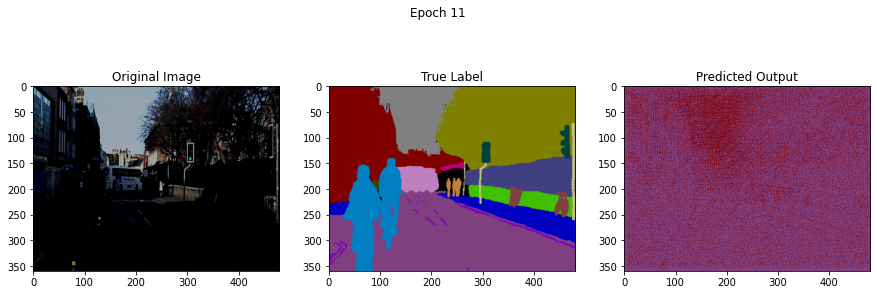

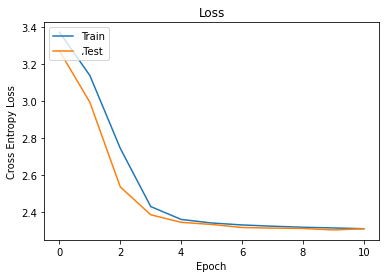

**********Epoch: 12 **********
 Epoch 12,  Iteration     9,  Loss: 2.314
 Epoch 12,  Iteration    19,  Loss: 2.309
 Epoch 12,  Iteration    29,  Loss: 2.319
 Epoch 12,  Iteration    39,  Loss: 2.331
 Epoch 12,  Iteration    49,  Loss: 2.322
 Epoch 12,  Iteration    59,  Loss: 2.311
 Epoch 12,  Iteration    69,  Loss: 2.308
 Epoch 12,  Iteration    79,  Loss: 2.302
 Epoch 12,  Iteration    89,  Loss: 2.300
 Epoch 12,  Iteration    99,  Loss: 2.294
 Epoch 12,  Iteration   109,  Loss: 2.295
 Epoch 12,  Iteration   119,  Loss: 2.301
 Epoch 12,  Iteration   129,  Loss: 2.304
 Epoch 12,  Iteration   139,  Loss: 2.301
TestLoss:  2.2714392476611667


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


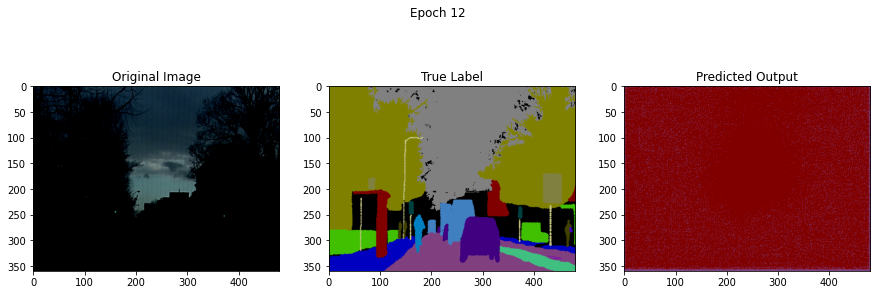

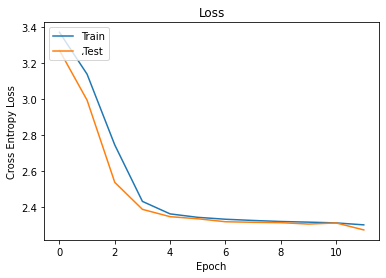

**********Epoch: 13 **********
 Epoch 13,  Iteration     9,  Loss: 2.220
 Epoch 13,  Iteration    19,  Loss: 2.339
 Epoch 13,  Iteration    29,  Loss: 2.336
 Epoch 13,  Iteration    39,  Loss: 2.311
 Epoch 13,  Iteration    49,  Loss: 2.289
 Epoch 13,  Iteration    59,  Loss: 2.287
 Epoch 13,  Iteration    69,  Loss: 2.274
 Epoch 13,  Iteration    79,  Loss: 2.260
 Epoch 13,  Iteration    89,  Loss: 2.260
 Epoch 13,  Iteration    99,  Loss: 2.257
 Epoch 13,  Iteration   109,  Loss: 2.253
 Epoch 13,  Iteration   119,  Loss: 2.250
 Epoch 13,  Iteration   129,  Loss: 2.251
 Epoch 13,  Iteration   139,  Loss: 2.247
TestLoss:  2.1940520140859814


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


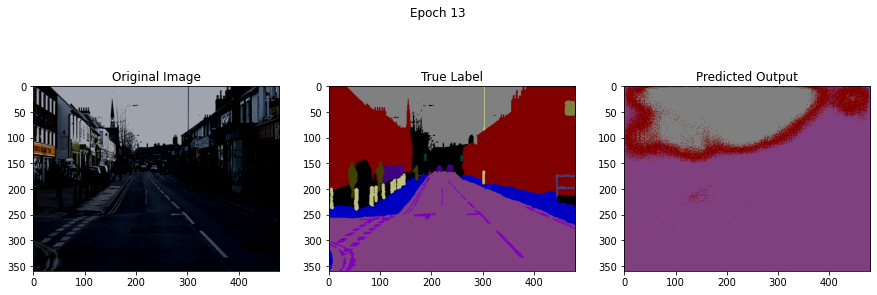

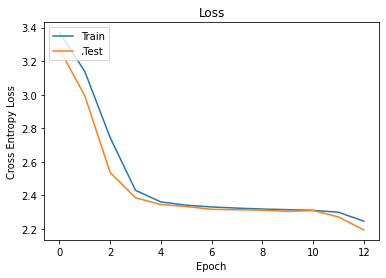

**********Epoch: 14 **********
 Epoch 14,  Iteration     9,  Loss: 2.190
 Epoch 14,  Iteration    19,  Loss: 2.185
 Epoch 14,  Iteration    29,  Loss: 2.174
 Epoch 14,  Iteration    39,  Loss: 2.180
 Epoch 14,  Iteration    49,  Loss: 2.183
 Epoch 14,  Iteration    59,  Loss: 2.182
 Epoch 14,  Iteration    69,  Loss: 2.175
 Epoch 14,  Iteration    79,  Loss: 2.171
 Epoch 14,  Iteration    89,  Loss: 2.163
 Epoch 14,  Iteration    99,  Loss: 2.165
 Epoch 14,  Iteration   109,  Loss: 2.168
 Epoch 14,  Iteration   119,  Loss: 2.167
 Epoch 14,  Iteration   129,  Loss: 2.169
 Epoch 14,  Iteration   139,  Loss: 2.174
TestLoss:  2.1381886435879602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


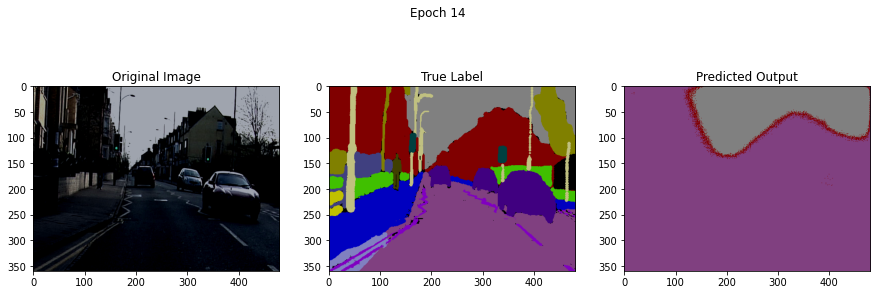

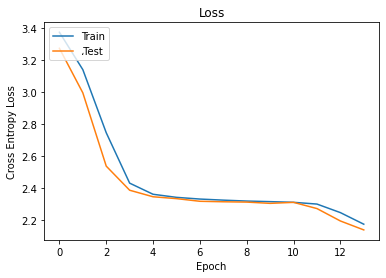

**********Epoch: 15 **********
 Epoch 15,  Iteration     9,  Loss: 2.160
 Epoch 15,  Iteration    19,  Loss: 2.140
 Epoch 15,  Iteration    29,  Loss: 2.110
 Epoch 15,  Iteration    39,  Loss: 2.113
 Epoch 15,  Iteration    49,  Loss: 2.112
 Epoch 15,  Iteration    59,  Loss: 2.108
 Epoch 15,  Iteration    69,  Loss: 2.121
 Epoch 15,  Iteration    79,  Loss: 2.122
 Epoch 15,  Iteration    89,  Loss: 2.127
 Epoch 15,  Iteration    99,  Loss: 2.124
 Epoch 15,  Iteration   109,  Loss: 2.115
 Epoch 15,  Iteration   119,  Loss: 2.113
 Epoch 15,  Iteration   129,  Loss: 2.113
 Epoch 15,  Iteration   139,  Loss: 2.109
TestLoss:  2.0608332488271923


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


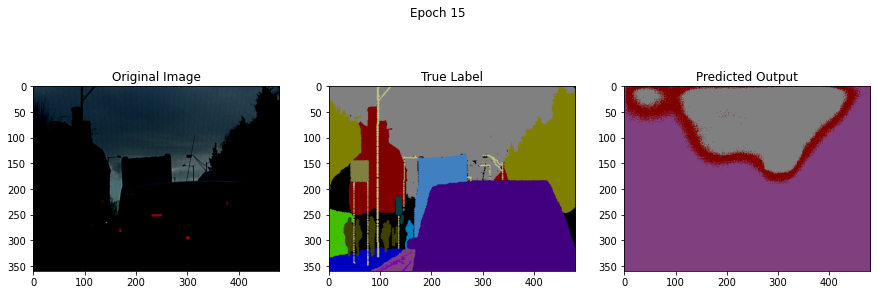

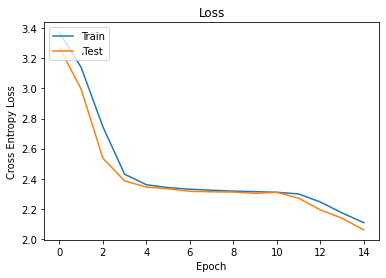

**********Epoch: 16 **********
 Epoch 16,  Iteration     9,  Loss: 2.116
 Epoch 16,  Iteration    19,  Loss: 2.095
 Epoch 16,  Iteration    29,  Loss: 2.102
 Epoch 16,  Iteration    39,  Loss: 2.092
 Epoch 16,  Iteration    49,  Loss: 2.099
 Epoch 16,  Iteration    59,  Loss: 2.080
 Epoch 16,  Iteration    69,  Loss: 2.076
 Epoch 16,  Iteration    79,  Loss: 2.073
 Epoch 16,  Iteration    89,  Loss: 2.074
 Epoch 16,  Iteration    99,  Loss: 2.064
 Epoch 16,  Iteration   109,  Loss: 2.060
 Epoch 16,  Iteration   119,  Loss: 2.056
 Epoch 16,  Iteration   129,  Loss: 2.056
 Epoch 16,  Iteration   139,  Loss: 2.049
TestLoss:  1.9829043481085036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


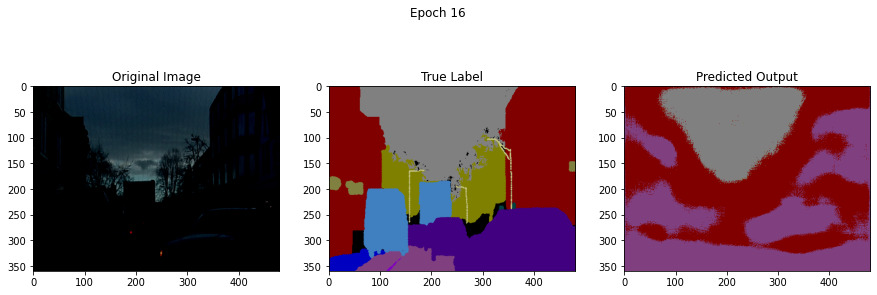

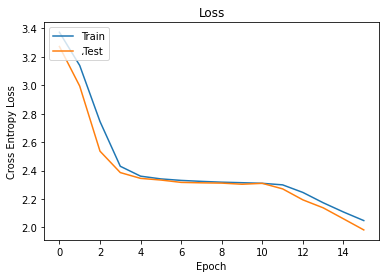

**********Epoch: 17 **********
 Epoch 17,  Iteration     9,  Loss: 2.052
 Epoch 17,  Iteration    19,  Loss: 2.038
 Epoch 17,  Iteration    29,  Loss: 2.015
 Epoch 17,  Iteration    39,  Loss: 2.013
 Epoch 17,  Iteration    49,  Loss: 1.999
 Epoch 17,  Iteration    59,  Loss: 1.987
 Epoch 17,  Iteration    69,  Loss: 1.979
 Epoch 17,  Iteration    79,  Loss: 1.982
 Epoch 17,  Iteration    89,  Loss: 1.980
 Epoch 17,  Iteration    99,  Loss: 1.973
 Epoch 17,  Iteration   109,  Loss: 1.971
 Epoch 17,  Iteration   119,  Loss: 1.968
 Epoch 17,  Iteration   129,  Loss: 1.964
 Epoch 17,  Iteration   139,  Loss: 1.960
TestLoss:  1.8773269885116153


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


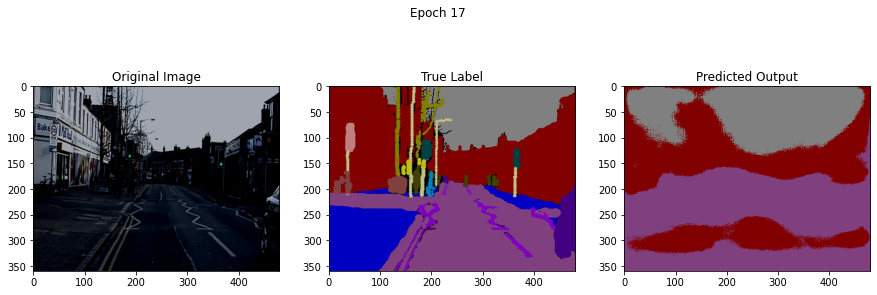

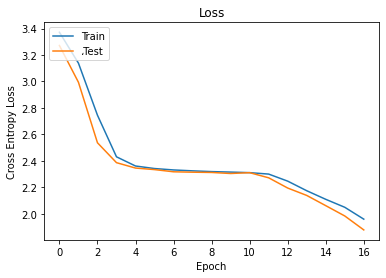

**********Epoch: 18 **********
 Epoch 18,  Iteration     9,  Loss: 1.912
 Epoch 18,  Iteration    19,  Loss: 1.898
 Epoch 18,  Iteration    29,  Loss: 1.922
 Epoch 18,  Iteration    39,  Loss: 1.905
 Epoch 18,  Iteration    49,  Loss: 1.898
 Epoch 18,  Iteration    59,  Loss: 1.896
 Epoch 18,  Iteration    69,  Loss: 1.877
 Epoch 18,  Iteration    79,  Loss: 1.870
 Epoch 18,  Iteration    89,  Loss: 1.867
 Epoch 18,  Iteration    99,  Loss: 1.869
 Epoch 18,  Iteration   109,  Loss: 1.858
 Epoch 18,  Iteration   119,  Loss: 1.856
 Epoch 18,  Iteration   129,  Loss: 1.854
 Epoch 18,  Iteration   139,  Loss: 1.851
TestLoss:  1.7483650346597035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


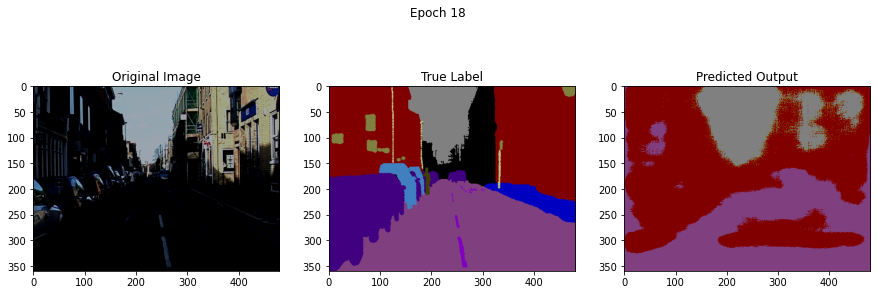

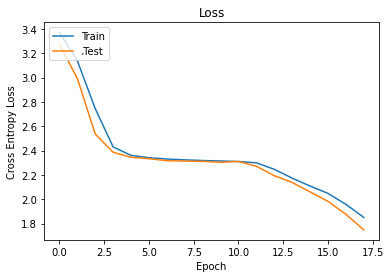

**********Epoch: 19 **********
 Epoch 19,  Iteration     9,  Loss: 1.779
 Epoch 19,  Iteration    19,  Loss: 1.789
 Epoch 19,  Iteration    29,  Loss: 1.776
 Epoch 19,  Iteration    39,  Loss: 1.776
 Epoch 19,  Iteration    49,  Loss: 1.773
 Epoch 19,  Iteration    59,  Loss: 1.757
 Epoch 19,  Iteration    69,  Loss: 1.752
 Epoch 19,  Iteration    79,  Loss: 1.750
 Epoch 19,  Iteration    89,  Loss: 1.753
 Epoch 19,  Iteration    99,  Loss: 1.756
 Epoch 19,  Iteration   109,  Loss: 1.756
 Epoch 19,  Iteration   119,  Loss: 1.759
 Epoch 19,  Iteration   129,  Loss: 1.757
 Epoch 19,  Iteration   139,  Loss: 1.754
TestLoss:  1.7100210355387793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


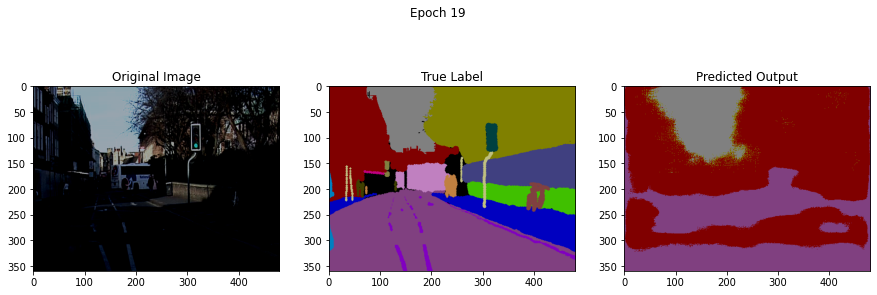

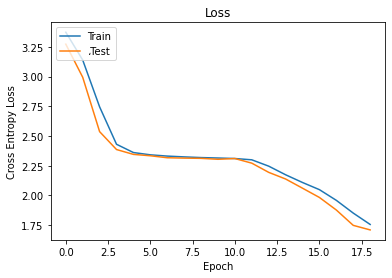

**********Epoch: 20 **********
 Epoch 20,  Iteration     9,  Loss: 1.736
 Epoch 20,  Iteration    19,  Loss: 1.731
 Epoch 20,  Iteration    29,  Loss: 1.734
 Epoch 20,  Iteration    39,  Loss: 1.729
 Epoch 20,  Iteration    49,  Loss: 1.720
 Epoch 20,  Iteration    59,  Loss: 1.718
 Epoch 20,  Iteration    69,  Loss: 1.719
 Epoch 20,  Iteration    79,  Loss: 1.709
 Epoch 20,  Iteration    89,  Loss: 1.694
 Epoch 20,  Iteration    99,  Loss: 1.693
 Epoch 20,  Iteration   109,  Loss: 1.689
 Epoch 20,  Iteration   119,  Loss: 1.681
 Epoch 20,  Iteration   129,  Loss: 1.677
 Epoch 20,  Iteration   139,  Loss: 1.683
TestLoss:  1.6470068726274703


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


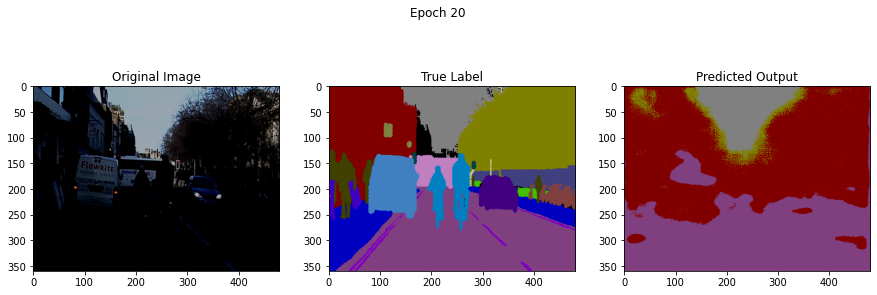

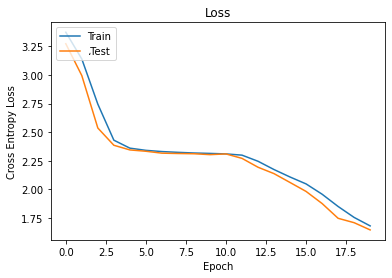

**********Epoch: 21 **********
 Epoch 21,  Iteration     9,  Loss: 1.643
 Epoch 21,  Iteration    19,  Loss: 1.635
 Epoch 21,  Iteration    29,  Loss: 1.629
 Epoch 21,  Iteration    39,  Loss: 1.654
 Epoch 21,  Iteration    49,  Loss: 1.648
 Epoch 21,  Iteration    59,  Loss: 1.638
 Epoch 21,  Iteration    69,  Loss: 1.633
 Epoch 21,  Iteration    79,  Loss: 1.629
 Epoch 21,  Iteration    89,  Loss: 1.627
 Epoch 21,  Iteration    99,  Loss: 1.624
 Epoch 21,  Iteration   109,  Loss: 1.621
 Epoch 21,  Iteration   119,  Loss: 1.616
 Epoch 21,  Iteration   129,  Loss: 1.620
 Epoch 21,  Iteration   139,  Loss: 1.621
TestLoss:  1.568349540233612


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


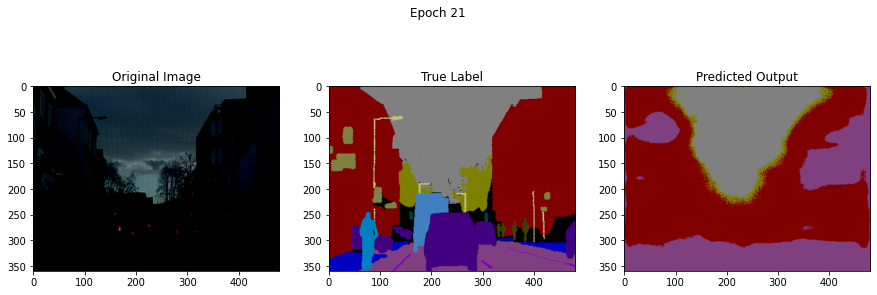

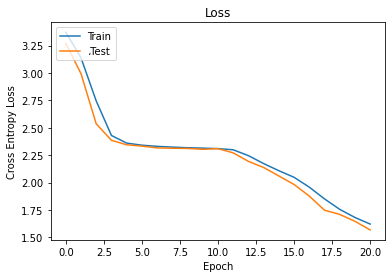

**********Epoch: 22 **********
 Epoch 22,  Iteration     9,  Loss: 1.603
 Epoch 22,  Iteration    19,  Loss: 1.596
 Epoch 22,  Iteration    29,  Loss: 1.586
 Epoch 22,  Iteration    39,  Loss: 1.575
 Epoch 22,  Iteration    49,  Loss: 1.564
 Epoch 22,  Iteration    59,  Loss: 1.571
 Epoch 22,  Iteration    69,  Loss: 1.580
 Epoch 22,  Iteration    79,  Loss: 1.571
 Epoch 22,  Iteration    89,  Loss: 1.564
 Epoch 22,  Iteration    99,  Loss: 1.567
 Epoch 22,  Iteration   109,  Loss: 1.572
 Epoch 22,  Iteration   119,  Loss: 1.597
 Epoch 22,  Iteration   129,  Loss: 1.602
 Epoch 22,  Iteration   139,  Loss: 1.599
TestLoss:  1.5370058019955952


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


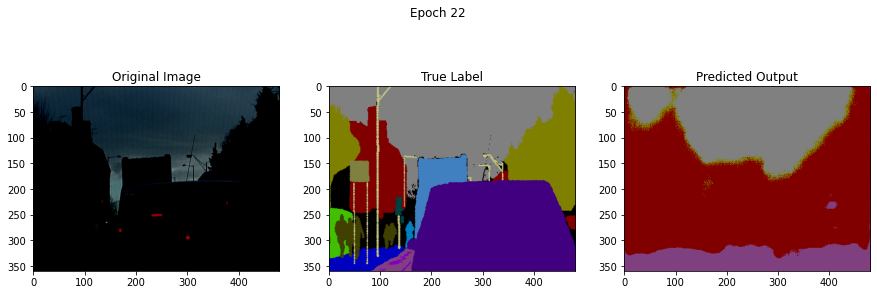

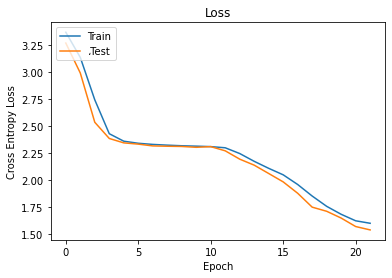

**********Epoch: 23 **********
 Epoch 23,  Iteration     9,  Loss: 1.554
 Epoch 23,  Iteration    19,  Loss: 1.557
 Epoch 23,  Iteration    29,  Loss: 1.551
 Epoch 23,  Iteration    39,  Loss: 1.591
 Epoch 23,  Iteration    49,  Loss: 1.587
 Epoch 23,  Iteration    59,  Loss: 1.576
 Epoch 23,  Iteration    69,  Loss: 1.581
 Epoch 23,  Iteration    79,  Loss: 1.570
 Epoch 23,  Iteration    89,  Loss: 1.568
 Epoch 23,  Iteration    99,  Loss: 1.561
 Epoch 23,  Iteration   109,  Loss: 1.559
 Epoch 23,  Iteration   119,  Loss: 1.552
 Epoch 23,  Iteration   129,  Loss: 1.552
 Epoch 23,  Iteration   139,  Loss: 1.548
TestLoss:  1.5073811014493306


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


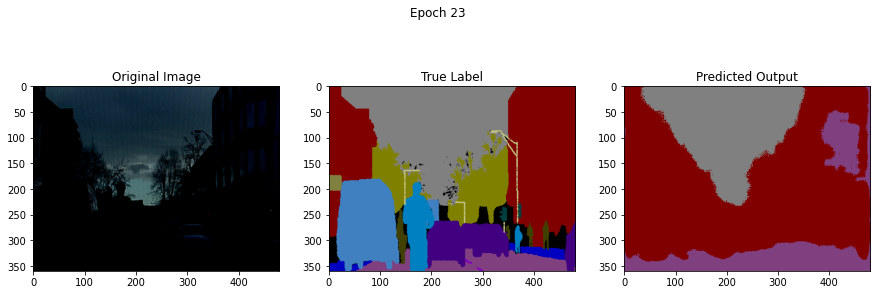

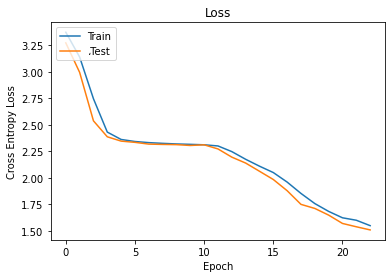

**********Epoch: 24 **********
 Epoch 24,  Iteration     9,  Loss: 1.410
 Epoch 24,  Iteration    19,  Loss: 1.447
 Epoch 24,  Iteration    29,  Loss: 1.478
 Epoch 24,  Iteration    39,  Loss: 1.512
 Epoch 24,  Iteration    49,  Loss: 1.522
 Epoch 24,  Iteration    59,  Loss: 1.516
 Epoch 24,  Iteration    69,  Loss: 1.520
 Epoch 24,  Iteration    79,  Loss: 1.508
 Epoch 24,  Iteration    89,  Loss: 1.506
 Epoch 24,  Iteration    99,  Loss: 1.510
 Epoch 24,  Iteration   109,  Loss: 1.517
 Epoch 24,  Iteration   119,  Loss: 1.525
 Epoch 24,  Iteration   129,  Loss: 1.522
 Epoch 24,  Iteration   139,  Loss: 1.521
TestLoss:  1.4931092725859747


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


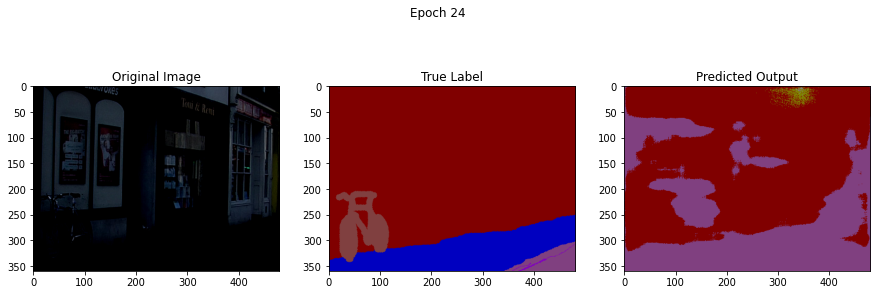

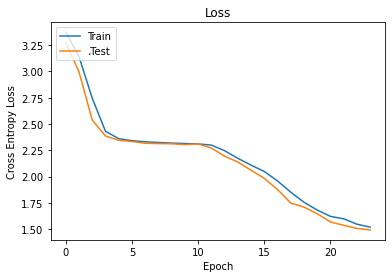

**********Epoch: 25 **********
 Epoch 25,  Iteration     9,  Loss: 1.554
 Epoch 25,  Iteration    19,  Loss: 1.523
 Epoch 25,  Iteration    29,  Loss: 1.521
 Epoch 25,  Iteration    39,  Loss: 1.496
 Epoch 25,  Iteration    49,  Loss: 1.511
 Epoch 25,  Iteration    59,  Loss: 1.521
 Epoch 25,  Iteration    69,  Loss: 1.516
 Epoch 25,  Iteration    79,  Loss: 1.512
 Epoch 25,  Iteration    89,  Loss: 1.513
 Epoch 25,  Iteration    99,  Loss: 1.515
 Epoch 25,  Iteration   109,  Loss: 1.510
 Epoch 25,  Iteration   119,  Loss: 1.506
 Epoch 25,  Iteration   129,  Loss: 1.509
 Epoch 25,  Iteration   139,  Loss: 1.510
TestLoss:  1.4856232470936246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


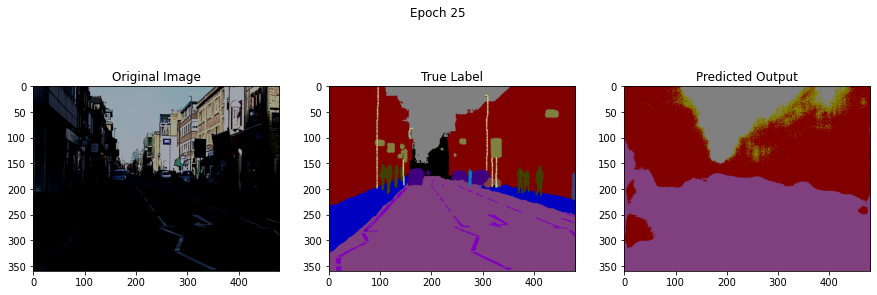

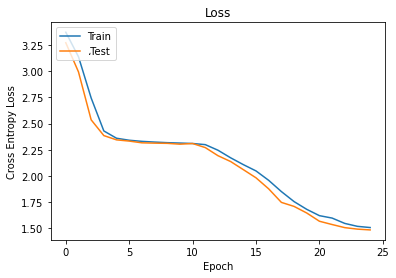

**********Epoch: 26 **********
 Epoch 26,  Iteration     9,  Loss: 1.539
 Epoch 26,  Iteration    19,  Loss: 1.465
 Epoch 26,  Iteration    29,  Loss: 1.498
 Epoch 26,  Iteration    39,  Loss: 1.497
 Epoch 26,  Iteration    49,  Loss: 1.525
 Epoch 26,  Iteration    59,  Loss: 1.523
 Epoch 26,  Iteration    69,  Loss: 1.516
 Epoch 26,  Iteration    79,  Loss: 1.515
 Epoch 26,  Iteration    89,  Loss: 1.507
 Epoch 26,  Iteration    99,  Loss: 1.498
 Epoch 26,  Iteration   109,  Loss: 1.493
 Epoch 26,  Iteration   119,  Loss: 1.488
 Epoch 26,  Iteration   129,  Loss: 1.487
 Epoch 26,  Iteration   139,  Loss: 1.483
TestLoss:  1.4598655733797286


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


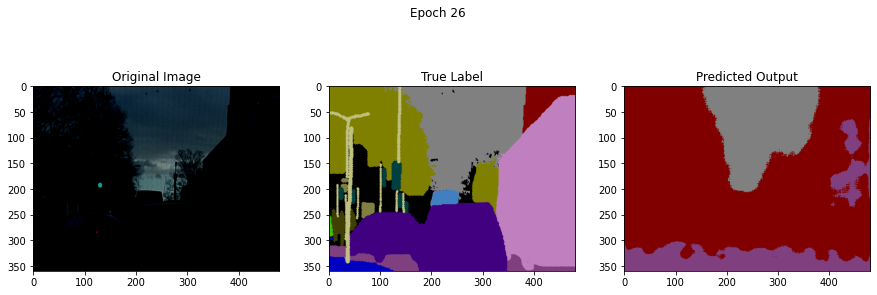

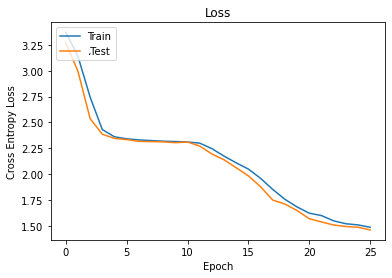

**********Epoch: 27 **********
 Epoch 27,  Iteration     9,  Loss: 1.435
 Epoch 27,  Iteration    19,  Loss: 1.454
 Epoch 27,  Iteration    29,  Loss: 1.510
 Epoch 27,  Iteration    39,  Loss: 1.506
 Epoch 27,  Iteration    49,  Loss: 1.484
 Epoch 27,  Iteration    59,  Loss: 1.476
 Epoch 27,  Iteration    69,  Loss: 1.467
 Epoch 27,  Iteration    79,  Loss: 1.469
 Epoch 27,  Iteration    89,  Loss: 1.463
 Epoch 27,  Iteration    99,  Loss: 1.460
 Epoch 27,  Iteration   109,  Loss: 1.459
 Epoch 27,  Iteration   119,  Loss: 1.462
 Epoch 27,  Iteration   129,  Loss: 1.462
 Epoch 27,  Iteration   139,  Loss: 1.463
TestLoss:  1.4389470054043665


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


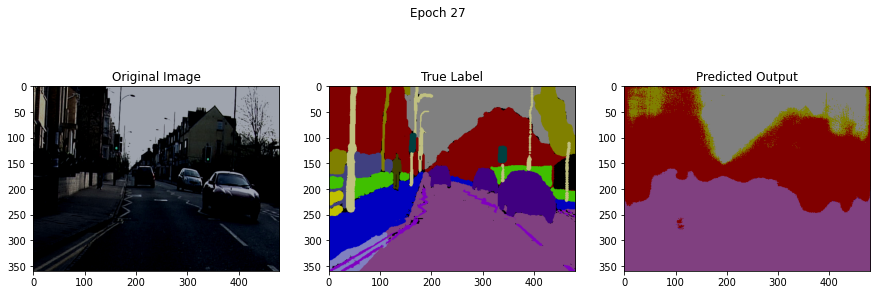

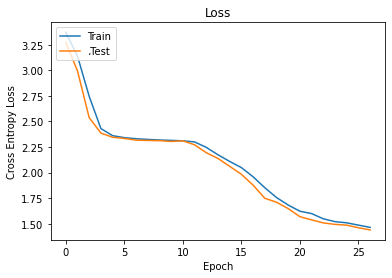

**********Epoch: 28 **********
 Epoch 28,  Iteration     9,  Loss: 1.403
 Epoch 28,  Iteration    19,  Loss: 1.454
 Epoch 28,  Iteration    29,  Loss: 1.445
 Epoch 28,  Iteration    39,  Loss: 1.425
 Epoch 28,  Iteration    49,  Loss: 1.439
 Epoch 28,  Iteration    59,  Loss: 1.424
 Epoch 28,  Iteration    69,  Loss: 1.443
 Epoch 28,  Iteration    79,  Loss: 1.447
 Epoch 28,  Iteration    89,  Loss: 1.450
 Epoch 28,  Iteration    99,  Loss: 1.444
 Epoch 28,  Iteration   109,  Loss: 1.448
 Epoch 28,  Iteration   119,  Loss: 1.455
 Epoch 28,  Iteration   129,  Loss: 1.456
 Epoch 28,  Iteration   139,  Loss: 1.458
TestLoss:  1.4961864451567333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


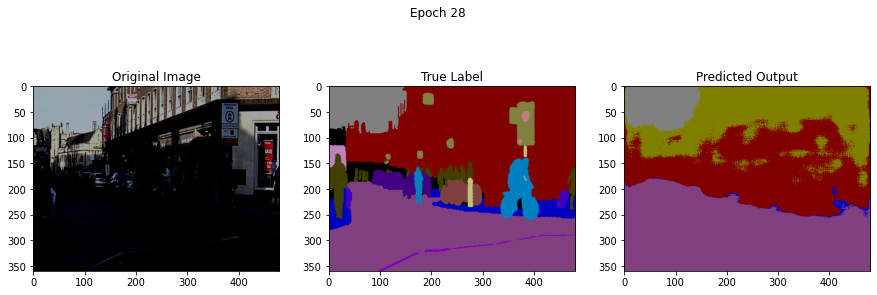

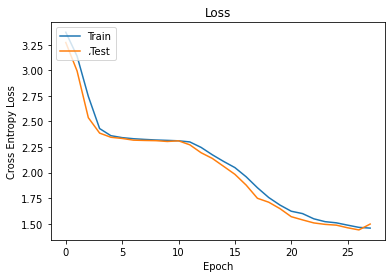

**********Epoch: 29 **********
 Epoch 29,  Iteration     9,  Loss: 1.436
 Epoch 29,  Iteration    19,  Loss: 1.459
 Epoch 29,  Iteration    29,  Loss: 1.478
 Epoch 29,  Iteration    39,  Loss: 1.482
 Epoch 29,  Iteration    49,  Loss: 1.496
 Epoch 29,  Iteration    59,  Loss: 1.482
 Epoch 29,  Iteration    69,  Loss: 1.486
 Epoch 29,  Iteration    79,  Loss: 1.463
 Epoch 29,  Iteration    89,  Loss: 1.462
 Epoch 29,  Iteration    99,  Loss: 1.456
 Epoch 29,  Iteration   109,  Loss: 1.449
 Epoch 29,  Iteration   119,  Loss: 1.445
 Epoch 29,  Iteration   129,  Loss: 1.446
 Epoch 29,  Iteration   139,  Loss: 1.448
TestLoss:  1.4218244320816464


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


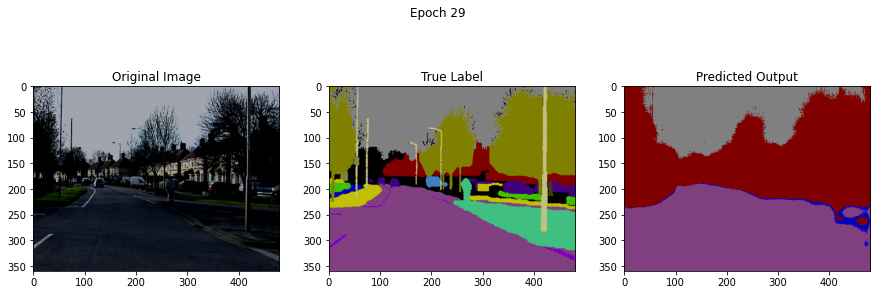

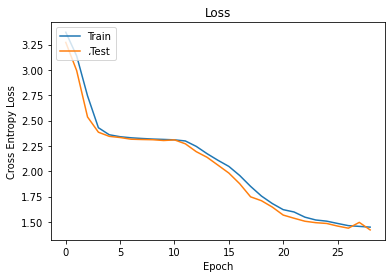

**********Epoch: 30 **********
 Epoch 30,  Iteration     9,  Loss: 1.415
 Epoch 30,  Iteration    19,  Loss: 1.391
 Epoch 30,  Iteration    29,  Loss: 1.426
 Epoch 30,  Iteration    39,  Loss: 1.418
 Epoch 30,  Iteration    49,  Loss: 1.429
 Epoch 30,  Iteration    59,  Loss: 1.425
 Epoch 30,  Iteration    69,  Loss: 1.429
 Epoch 30,  Iteration    79,  Loss: 1.425
 Epoch 30,  Iteration    89,  Loss: 1.422
 Epoch 30,  Iteration    99,  Loss: 1.420
 Epoch 30,  Iteration   109,  Loss: 1.423
 Epoch 30,  Iteration   119,  Loss: 1.421
 Epoch 30,  Iteration   129,  Loss: 1.426
 Epoch 30,  Iteration   139,  Loss: 1.426
TestLoss:  1.384089168575075


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


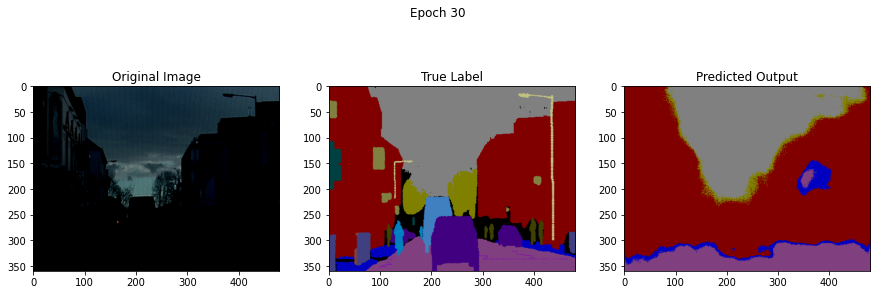

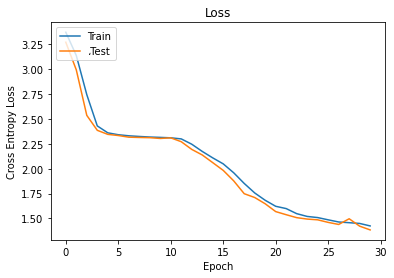

**********Epoch: 31 **********
 Epoch 31,  Iteration     9,  Loss: 1.380
 Epoch 31,  Iteration    19,  Loss: 1.342
 Epoch 31,  Iteration    29,  Loss: 1.374
 Epoch 31,  Iteration    39,  Loss: 1.390
 Epoch 31,  Iteration    49,  Loss: 1.429
 Epoch 31,  Iteration    59,  Loss: 1.424
 Epoch 31,  Iteration    69,  Loss: 1.420
 Epoch 31,  Iteration    79,  Loss: 1.417
 Epoch 31,  Iteration    89,  Loss: 1.433
 Epoch 31,  Iteration    99,  Loss: 1.423
 Epoch 31,  Iteration   109,  Loss: 1.422
 Epoch 31,  Iteration   119,  Loss: 1.416
 Epoch 31,  Iteration   129,  Loss: 1.416
 Epoch 31,  Iteration   139,  Loss: 1.413
TestLoss:  1.4109564423561096


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


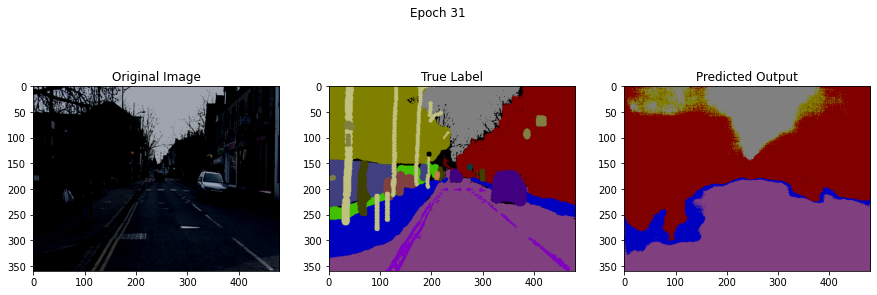

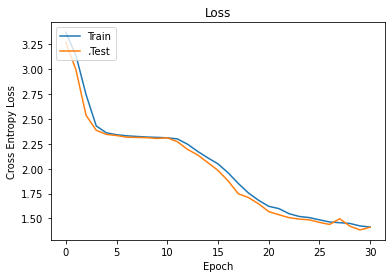

**********Epoch: 32 **********
 Epoch 32,  Iteration     9,  Loss: 1.426
 Epoch 32,  Iteration    19,  Loss: 1.415
 Epoch 32,  Iteration    29,  Loss: 1.394
 Epoch 32,  Iteration    39,  Loss: 1.382
 Epoch 32,  Iteration    49,  Loss: 1.376
 Epoch 32,  Iteration    59,  Loss: 1.388
 Epoch 32,  Iteration    69,  Loss: 1.403
 Epoch 32,  Iteration    79,  Loss: 1.409
 Epoch 32,  Iteration    89,  Loss: 1.412
 Epoch 32,  Iteration    99,  Loss: 1.412
 Epoch 32,  Iteration   109,  Loss: 1.408
 Epoch 32,  Iteration   119,  Loss: 1.406
 Epoch 32,  Iteration   129,  Loss: 1.400
 Epoch 32,  Iteration   139,  Loss: 1.411
TestLoss:  1.4358607298798032


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


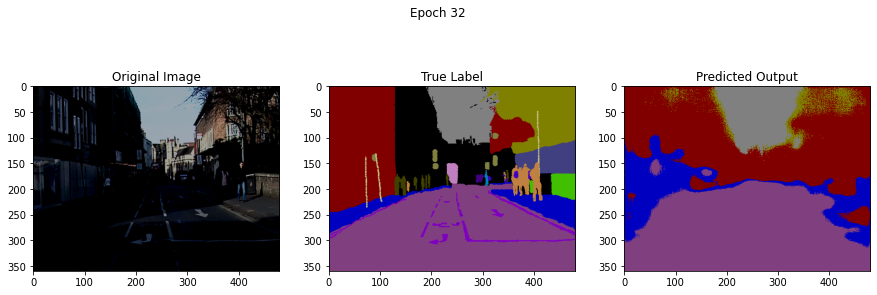

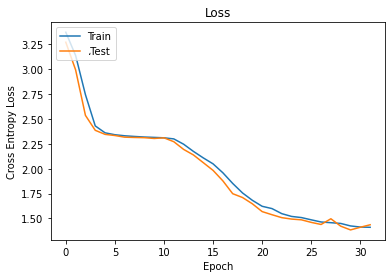

**********Epoch: 33 **********
 Epoch 33,  Iteration     9,  Loss: 1.393
 Epoch 33,  Iteration    19,  Loss: 1.394
 Epoch 33,  Iteration    29,  Loss: 1.417
 Epoch 33,  Iteration    39,  Loss: 1.409
 Epoch 33,  Iteration    49,  Loss: 1.409
 Epoch 33,  Iteration    59,  Loss: 1.409
 Epoch 33,  Iteration    69,  Loss: 1.403
 Epoch 33,  Iteration    79,  Loss: 1.403
 Epoch 33,  Iteration    89,  Loss: 1.402
 Epoch 33,  Iteration    99,  Loss: 1.394
 Epoch 33,  Iteration   109,  Loss: 1.398
 Epoch 33,  Iteration   119,  Loss: 1.398
 Epoch 33,  Iteration   129,  Loss: 1.394
 Epoch 33,  Iteration   139,  Loss: 1.397
TestLoss:  1.3698578377564747


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


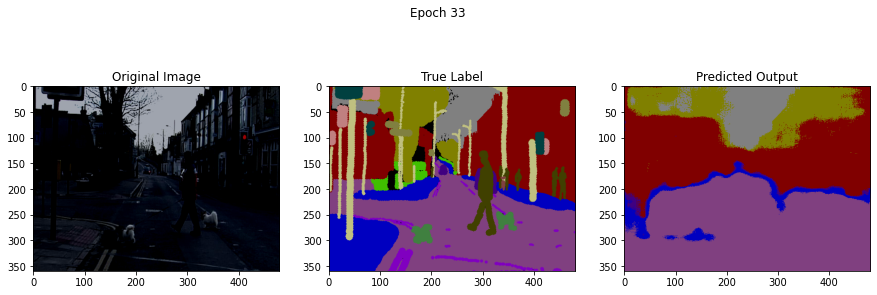

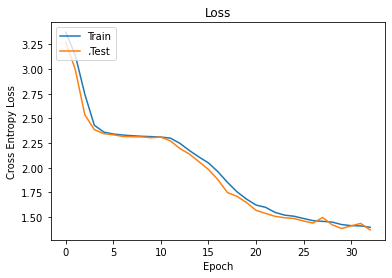

**********Epoch: 34 **********
 Epoch 34,  Iteration     9,  Loss: 1.372
 Epoch 34,  Iteration    19,  Loss: 1.313
 Epoch 34,  Iteration    29,  Loss: 1.318
 Epoch 34,  Iteration    39,  Loss: 1.350
 Epoch 34,  Iteration    49,  Loss: 1.365
 Epoch 34,  Iteration    59,  Loss: 1.372
 Epoch 34,  Iteration    69,  Loss: 1.384
 Epoch 34,  Iteration    79,  Loss: 1.380
 Epoch 34,  Iteration    89,  Loss: 1.391
 Epoch 34,  Iteration    99,  Loss: 1.387
 Epoch 34,  Iteration   109,  Loss: 1.384
 Epoch 34,  Iteration   119,  Loss: 1.381
 Epoch 34,  Iteration   129,  Loss: 1.381
 Epoch 34,  Iteration   139,  Loss: 1.385
TestLoss:  1.3482810623115964


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


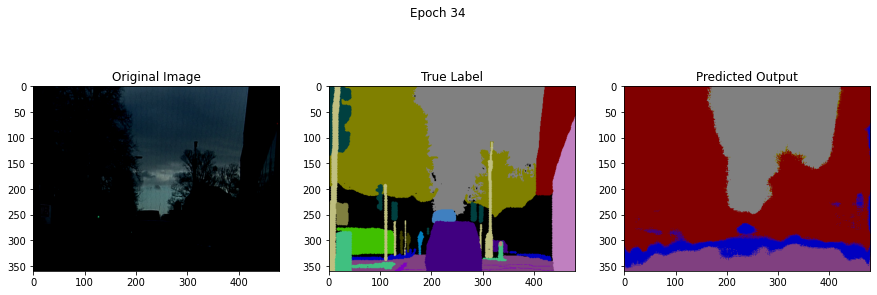

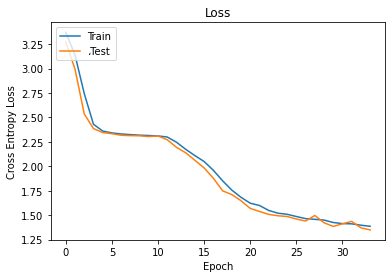

**********Epoch: 35 **********
 Epoch 35,  Iteration     9,  Loss: 1.306
 Epoch 35,  Iteration    19,  Loss: 1.375
 Epoch 35,  Iteration    29,  Loss: 1.396
 Epoch 35,  Iteration    39,  Loss: 1.398
 Epoch 35,  Iteration    49,  Loss: 1.398
 Epoch 35,  Iteration    59,  Loss: 1.402
 Epoch 35,  Iteration    69,  Loss: 1.398
 Epoch 35,  Iteration    79,  Loss: 1.398
 Epoch 35,  Iteration    89,  Loss: 1.395
 Epoch 35,  Iteration    99,  Loss: 1.384
 Epoch 35,  Iteration   109,  Loss: 1.395
 Epoch 35,  Iteration   119,  Loss: 1.399
 Epoch 35,  Iteration   129,  Loss: 1.400
 Epoch 35,  Iteration   139,  Loss: 1.399
TestLoss:  1.3467782537142436


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


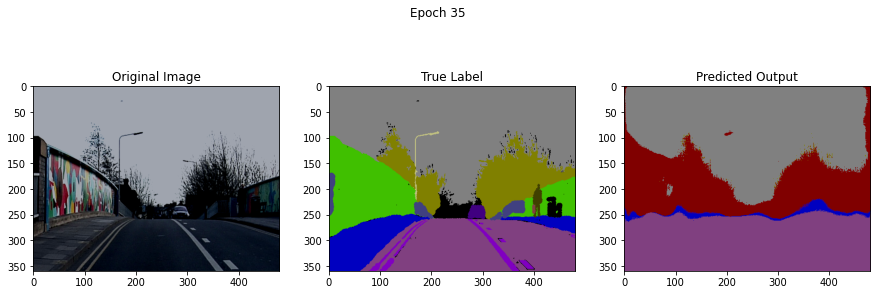

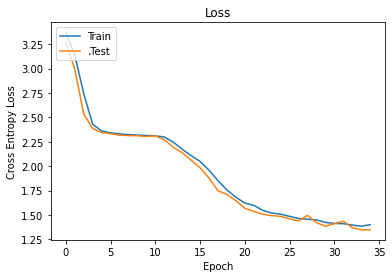

**********Epoch: 36 **********
 Epoch 36,  Iteration     9,  Loss: 1.339
 Epoch 36,  Iteration    19,  Loss: 1.366
 Epoch 36,  Iteration    29,  Loss: 1.343
 Epoch 36,  Iteration    39,  Loss: 1.340
 Epoch 36,  Iteration    49,  Loss: 1.356
 Epoch 36,  Iteration    59,  Loss: 1.354
 Epoch 36,  Iteration    69,  Loss: 1.361
 Epoch 36,  Iteration    79,  Loss: 1.365
 Epoch 36,  Iteration    89,  Loss: 1.363
 Epoch 36,  Iteration    99,  Loss: 1.366
 Epoch 36,  Iteration   109,  Loss: 1.367
 Epoch 36,  Iteration   119,  Loss: 1.364
 Epoch 36,  Iteration   129,  Loss: 1.365
 Epoch 36,  Iteration   139,  Loss: 1.368
TestLoss:  1.3683731423483954


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


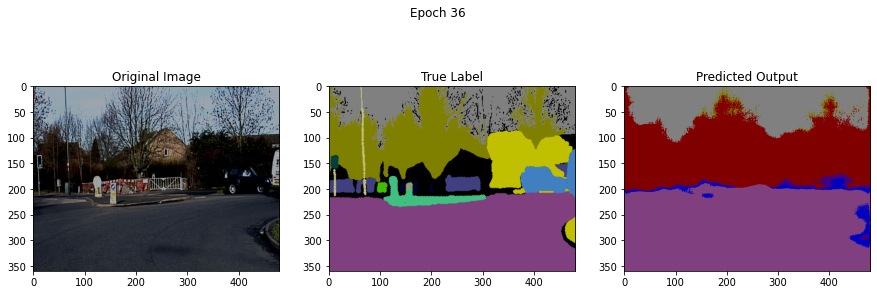

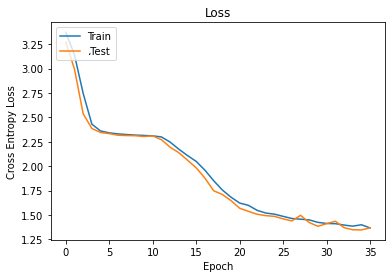

**********Epoch: 37 **********
 Epoch 37,  Iteration     9,  Loss: 1.409
 Epoch 37,  Iteration    19,  Loss: 1.379
 Epoch 37,  Iteration    29,  Loss: 1.381
 Epoch 37,  Iteration    39,  Loss: 1.371
 Epoch 37,  Iteration    49,  Loss: 1.354
 Epoch 37,  Iteration    59,  Loss: 1.358
 Epoch 37,  Iteration    69,  Loss: 1.361
 Epoch 37,  Iteration    79,  Loss: 1.363
 Epoch 37,  Iteration    89,  Loss: 1.350
 Epoch 37,  Iteration    99,  Loss: 1.347
 Epoch 37,  Iteration   109,  Loss: 1.351
 Epoch 37,  Iteration   119,  Loss: 1.360
 Epoch 37,  Iteration   129,  Loss: 1.355
 Epoch 37,  Iteration   139,  Loss: 1.350
TestLoss:  1.3153925935427349


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


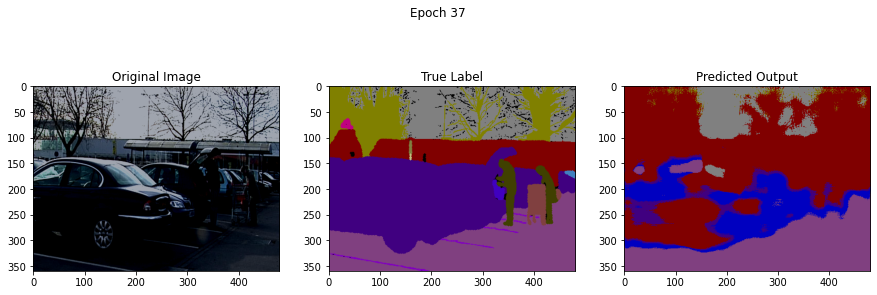

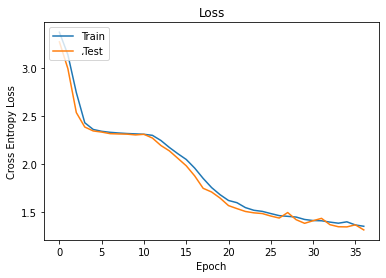

**********Epoch: 38 **********
 Epoch 38,  Iteration     9,  Loss: 1.296
 Epoch 38,  Iteration    19,  Loss: 1.366
 Epoch 38,  Iteration    29,  Loss: 1.338
 Epoch 38,  Iteration    39,  Loss: 1.368
 Epoch 38,  Iteration    49,  Loss: 1.375
 Epoch 38,  Iteration    59,  Loss: 1.366
 Epoch 38,  Iteration    69,  Loss: 1.362
 Epoch 38,  Iteration    79,  Loss: 1.362
 Epoch 38,  Iteration    89,  Loss: 1.363
 Epoch 38,  Iteration    99,  Loss: 1.364
 Epoch 38,  Iteration   109,  Loss: 1.361
 Epoch 38,  Iteration   119,  Loss: 1.363
 Epoch 38,  Iteration   129,  Loss: 1.361
 Epoch 38,  Iteration   139,  Loss: 1.357
TestLoss:  1.321607642703586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


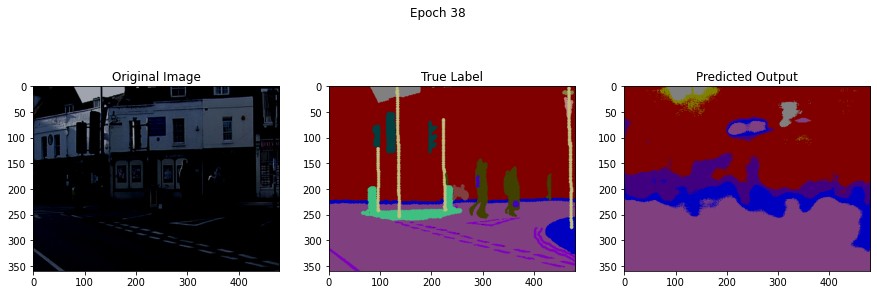

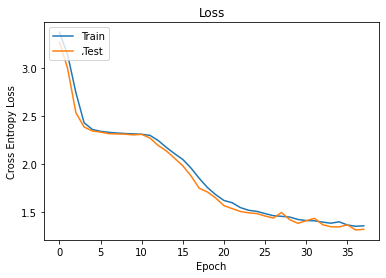

**********Epoch: 39 **********
 Epoch 39,  Iteration     9,  Loss: 1.290
 Epoch 39,  Iteration    19,  Loss: 1.310
 Epoch 39,  Iteration    29,  Loss: 1.331
 Epoch 39,  Iteration    39,  Loss: 1.316
 Epoch 39,  Iteration    49,  Loss: 1.311
 Epoch 39,  Iteration    59,  Loss: 1.334
 Epoch 39,  Iteration    69,  Loss: 1.347
 Epoch 39,  Iteration    79,  Loss: 1.350
 Epoch 39,  Iteration    89,  Loss: 1.348
 Epoch 39,  Iteration    99,  Loss: 1.356
 Epoch 39,  Iteration   109,  Loss: 1.358
 Epoch 39,  Iteration   119,  Loss: 1.351
 Epoch 39,  Iteration   129,  Loss: 1.351
 Epoch 39,  Iteration   139,  Loss: 1.351
TestLoss:  1.325312425692876


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


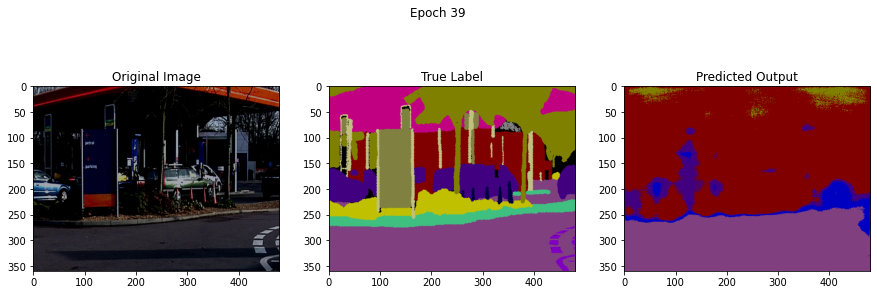

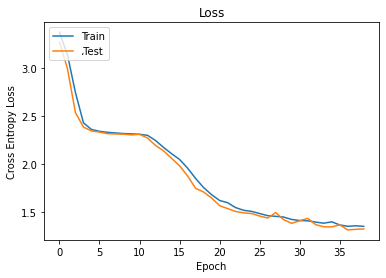

**********Epoch: 40 **********
 Epoch 40,  Iteration     9,  Loss: 1.223
 Epoch 40,  Iteration    19,  Loss: 1.286
 Epoch 40,  Iteration    29,  Loss: 1.286
 Epoch 40,  Iteration    39,  Loss: 1.303


In [ ]:
for epoch in range(60):  # loop over the dataset multiple times
  print("**********Epoch:",epoch+1,"**********")
  lossEpoch = 0.0
  cnt = 0
  running_loss = 0.0
  net = net.train()
  for imData, imLabel in trainDataCamvid:
    cnt = cnt +1
    if torch.cuda.is_available:
      img = gradEnb(imData).cuda()
      imLabel =  gradEnb(imLabel).cuda()
    else:
      img = Variable(img)
      imLabel = Variable(imLabel)
    outputs = net(img)
    # forward + backward + optimize
    outputs = net(img)
    imLabel_Clnmb = torch.argmax(imLabel, dim=1)
    loss = criterion(outputs, imLabel_Clnmb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # print statistics
    running_loss += loss.item()
    if cnt % 10 == 9:    
        print(' Epoch %d,  Iteration %5d,  Loss: %.3f' %
              (epoch + 1, cnt, running_loss /(cnt)))
        
  testLoss = calcTestLoss(testDataCamvid, net, criterion)
  print("TestLoss: ", testLoss)
  showResults(epoch_ = epoch+1, originalImg = img.cpu().numpy(), label = imLabel.cpu().numpy(), predictedResult = outputs.cpu())
  lossTrainHist.append(running_loss/cnt)
  lossTestHist.append(testLoss)
  epochHist.append(epoch)
  plotLoss(epochHist, lossTrainHist, lossTestHist)

  
    
            
          

print('Finished Training')